In [91]:
import numpy as np
import pandas as pd
def read_file(file):
    auc_roc = "Current ROC-AUC score on the test set:  "
    auc_pr = "Current AUC PR score on the test set:  "
    data = {
        auc_roc: [],
        auc_pr: [],
    }
    with open(file) as f:
        for l in f:
            for line in data:
                if l[:len(line)] == line:
                    data[line].append(float(l[len(line):-2]))

    auc_roc_scores = np.array(data[auc_roc])
    #print("AUC ROC mean: ", auc_roc_scores.mean())
    #print("AUC ROC median: ", np.median(auc_roc_scores))
    #print("AUC ROC std: ", auc_roc_scores.std())

    auc_pr_scores = np.array(data[auc_pr])
    #print("AUC PR mean: ", auc_pr_scores.mean())
    #print("AUC ROC median: ", np.median(auc_roc_scores))
    #print("AUC PR std: ", auc_pr_scores.std())

    if len(auc_roc_scores) == 1:
        auc_roc_scores = [auc_roc_scores[0]] * 10
    print(f"File: {file}")
    print(f"Mean: {np.array(auc_roc_scores).mean()}")
    print(f"STD: {np.array(auc_roc_scores).std()}")
    return auc_roc_scores

In [92]:
#from https://rowannicholls.github.io/python/graphs/ax_based/boxplots_significance.html
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib import rcParams
def box_and_whisker(data, title, ylabel, xticklabels, title_suffix, figsize = (20, 20)):
    """
    Create a box-and-whisker plot with significance bars.
    """
    labelsize = 30
    font = {'family' : 'normal',
        'size'   : labelsize}

    plt.rc('font', **font)

    plt.figure(figsize=figsize)
    ax = plt.axes()
    sorted_data = sorted(enumerate(data), key = lambda x: np.median(x[1]))
    data = [x for _, x in sorted_data]
    xticklabels = list(xticklabels)
    xticklabels = [xticklabels[i] for i, _ in sorted_data]
    bp = ax.boxplot(data, widths=0.6, patch_artist=True)
    # Graph title
    ax.set_title(title, fontsize=labelsize)
    # Label y-axis
    ax.set_ylabel(ylabel, fontsize=labelsize)
    # Label x-axis ticks
    ax.set_xticklabels(xticklabels, fontsize = labelsize)
    # Hide x-axis major ticks
    ax.tick_params(axis='x', which='major', length=0)
    plt.xticks(rotation=30)
    # Show x-axis minor ticks
    xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
    ax.set_xticks(xticks, minor=True)
    # Clean up the appearance
    ax.tick_params(axis='x', which='minor', length=3, width=1)
 

    # Change the colour of the boxes to Seaborn's 'pastel' palette
    colors = sns.color_palette('pastel')
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Colour of the median lines
    plt.setp(bp['medians'], color='k')

    # Check for statistical significance
    significant_combinations = []
    # Check from the outside pairs of boxes inwards
    ls = list(range(1, len(data) + 1))
    combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
    for c in combinations:
        data1 = data[c[0] - 1]
        data2 = data[c[1] - 1]
        # Significance
        #U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        U, p = stats.ttest_ind(data1, data2)
        if p < 0.05 and c[1] == len(ls):
            significant_combinations.append([c, p])

    # Get info about y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom

    # Significance bars
    for i, significant_combination in enumerate(significant_combinations):
        # Columns corresponding to the datasets of interest
        x1 = significant_combination[0][0]
        x2 = significant_combination[0][1]
        # What level is this bar among the bars above the plot?
        level = len(significant_combinations) - i
        # Plot the bar
        bar_height = (yrange * 0.08 * level) + top
        bar_tips = bar_height - (yrange * 0.02)
        plt.plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
        # Significance level
        p = significant_combination[1]
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        text_height = bar_height + (yrange * 0.01)
        plt.text((x1 + x2) * 0.5, text_height, "p-value = " + "{:.2e}".format(p), ha='center', c='k')

    # Adjust y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom
    ax.set_ylim(bottom - 0.02 * yrange, top)

    # Annotate sample size below each box
    for i, dataset in enumerate(data):
        sample_size = len(dataset)
        ax.text(i + 1, bottom, fr'n = {sample_size}', ha='center', size='x-small')
#     plt.rcParams.update({
#     "figure.facecolor":  (0, 0.0, 0.0, 0.3),  # red   with alpha = 30%
#     "axes.facecolor":    (0.0, 0, 0.0, 0.5),  # green with alpha = 50%
#     "savefig.facecolor": (0.0, 0.0, 0, 0.2),  # blue  with alpha = 20%
# })
    plt.savefig(f"{title_suffix}.png", transparent=False, facecolor='white')
    plt.show()

In [93]:
output_path = '../outputs/MIMICIV-Experiments/'
model_to_file = {
                "LSTM + focal": output_path + 'lstm_focal/lstm.txt', 
                "LSTM": output_path + 'lstm/lstm_bce.txt',
                'RNN + focal': output_path + 'rnn_focal/rnn.txt', 
                'RNN': output_path + 'rnn/rnn_bce.txt', 
                'XGBoost': output_path + 'xgboost/xgboost.txt',
                'RF': output_path + 'random_forest/random_forest.txt',
                'RatchetEHR': output_path + 'tl_reconstruction_output.txt'}

In [94]:
model_to_roc_scores = {model: read_file(file) for model, file in model_to_file.items()}
model_to_roc_scores["RF"] = [0.70, 0.798, 0.729, 0.722, 0.7226, 0.764, 0.7996, 0.781, 
                             0.66974,  0.704362 ]
model_to_roc_scores["XGBoost"] = [0.73289, 0.7311, 0.7441, 0.79671, 0.7714, 0.80040, 
                                  0.7976, 0.7190, 0.76009,  0.7545]

File: ../outputs/MIMICIV-Experiments/lstm_focal/lstm.txt
Mean: 0.7243595083043053
STD: 0.05967941130278758
File: ../outputs/MIMICIV-Experiments/lstm/lstm_bce.txt
Mean: 0.7245885708516325
STD: 0.051515909046010944
File: ../outputs/MIMICIV-Experiments/rnn_focal/rnn.txt
Mean: 0.7440588873744252
STD: 0.026357440486104274
File: ../outputs/MIMICIV-Experiments/rnn/rnn_bce.txt
Mean: 0.7145647180574481
STD: 0.03653299391024111
File: ../outputs/MIMICIV-Experiments/xgboost/xgboost.txt
Mean: 0.7659626861347701
STD: 1.1102230246251565e-16
File: ../outputs/MIMICIV-Experiments/random_forest/random_forest.txt
Mean: 0.7842507290882039
STD: 0.005096672607487705
File: ../outputs/MIMICIV-Experiments/tl_reconstruction_output.txt
Mean: 0.7995936190620411
STD: 0.0049138085737507955


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

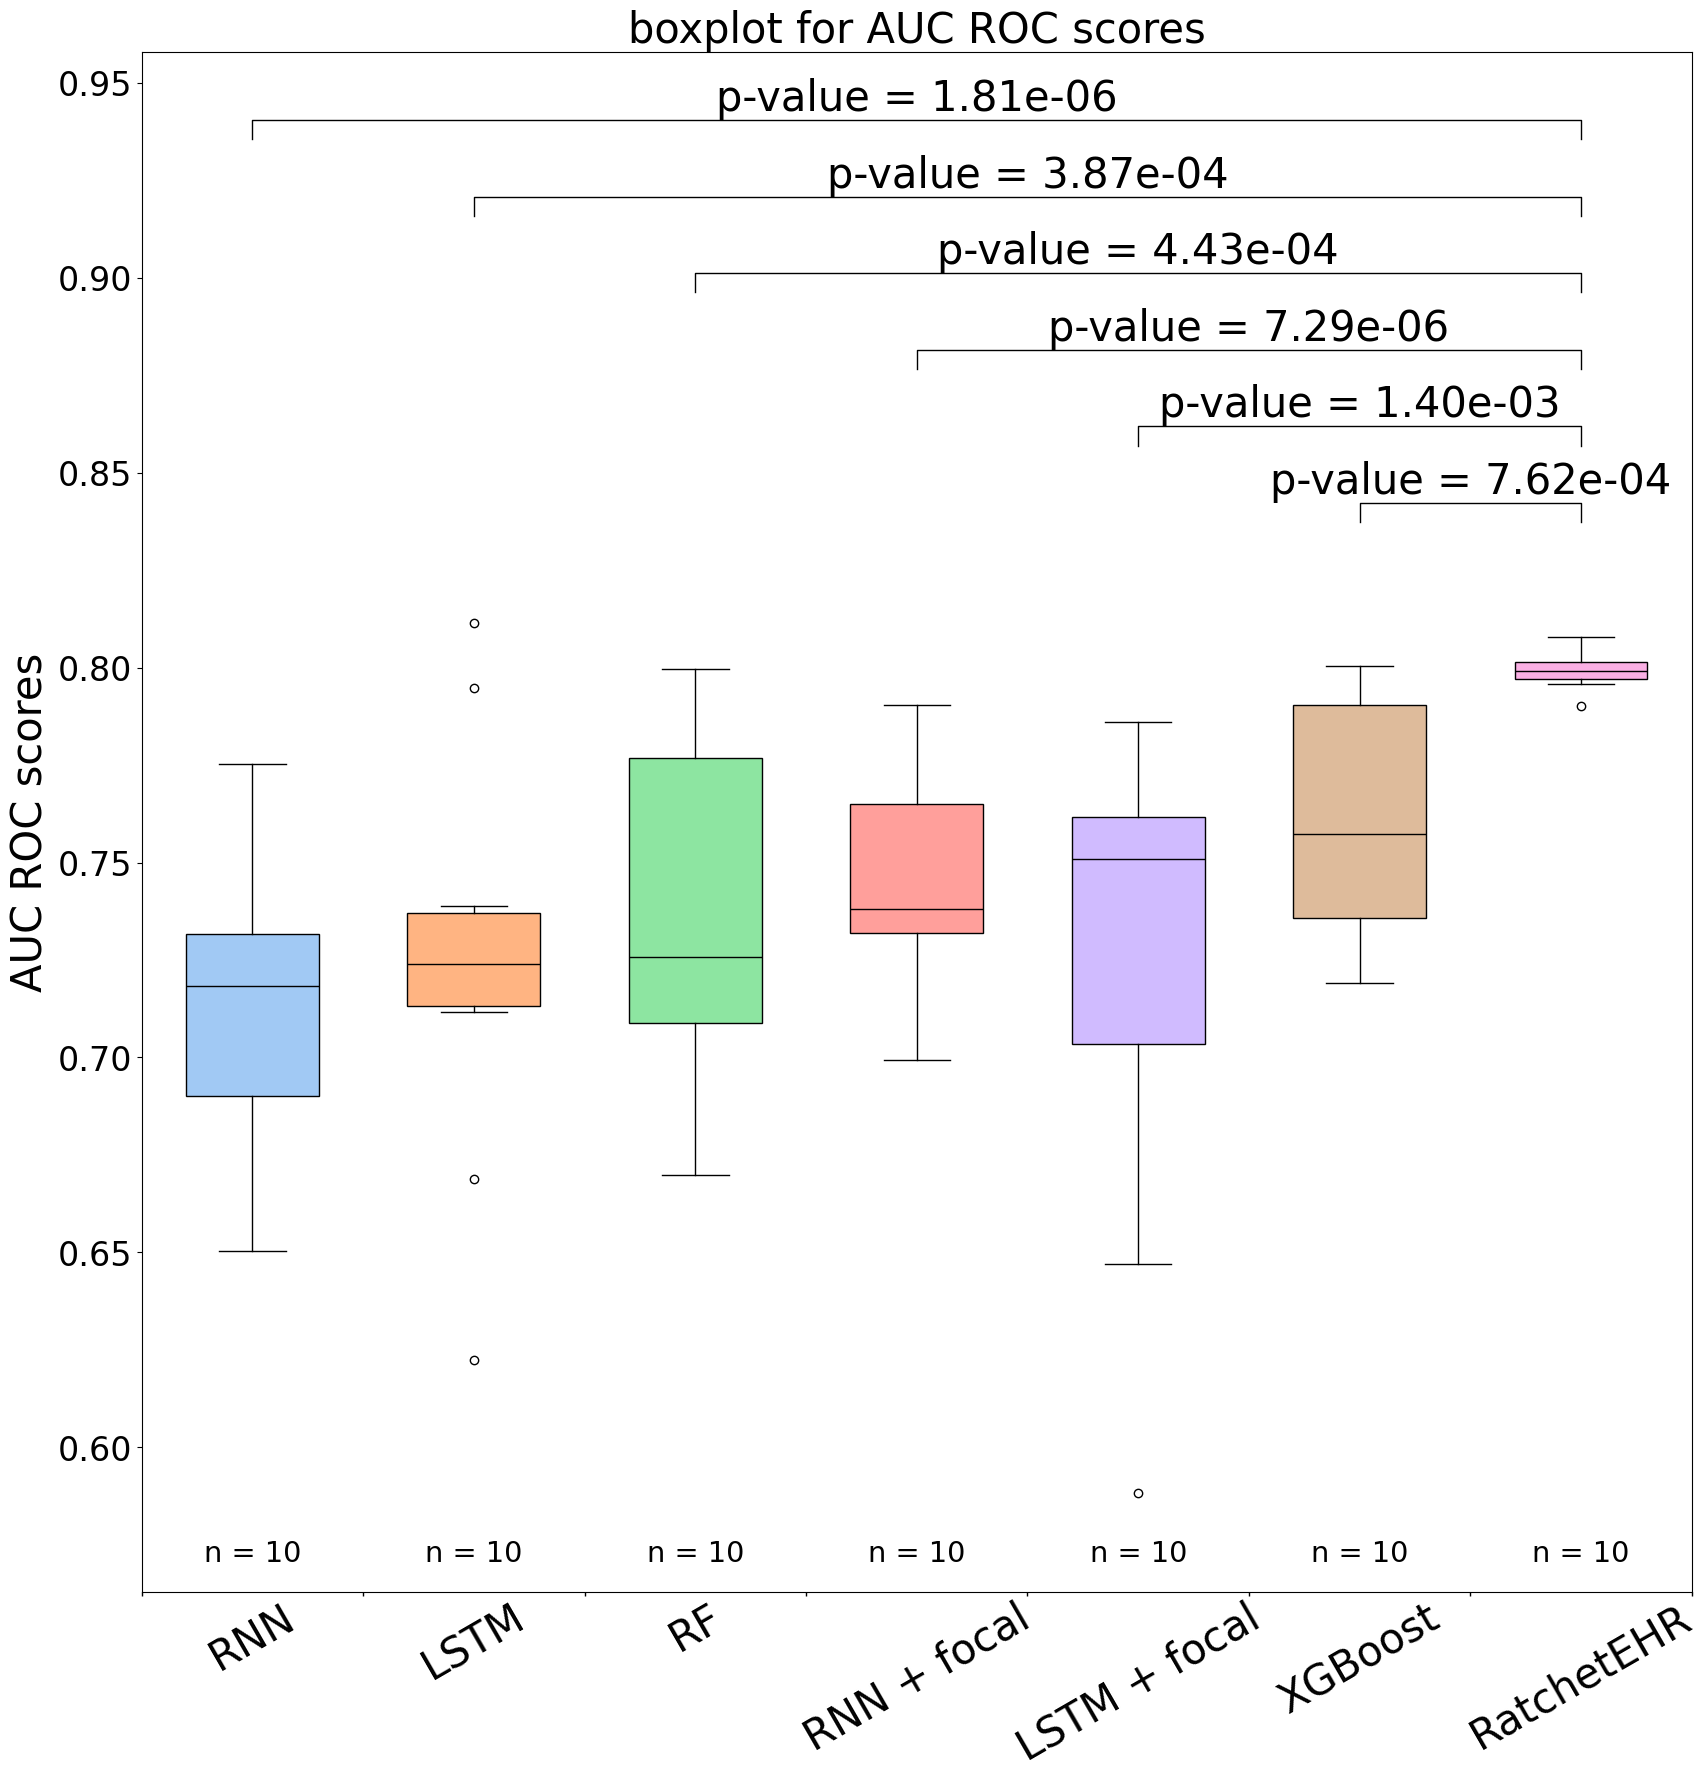

In [95]:
box_and_whisker(list(model_to_roc_scores.values()),
                 "boxplot for AUC ROC scores", 
                 "AUC ROC scores", model_to_file.keys(), "Benchmark")

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

File: ../outputs/MIMICIV-Experiments/ratchet_bce_loss/tl_reconstruction_output_bce_loss.tx
Mean: 0.7943295976576296
STD: 0.012091290230583203
File: ../outputs/MIMICIV-Experiments/ratchet_no_child_tuning/tl_reconstruction_output_no_child_tuning.tx
Mean: 0.8009856630824366
STD: 0.0023513733496525148
File: ../outputs/MIMICIV-Experiments/ratchet_no_sampler/tl_reconstruction_output_no_sampler.tx
Mean: 0.7989651168660703
STD: 0.00464800043713306
File: ../outputs/MIMICIV-Experiments/ratchet_no_gct/tl_reconstruction_no_gct.txt
Mean: 0.7111022767428925
STD: 0.05561079634818428
File: ../outputs/MIMICIV-Experiments/ratchet_no_gct_tl/tl_reconstruction_no_gct_tl.txt
Mean: 0.7505205966984693
STD: 0.037376781018725304
File: ../outputs/MIMICIV-Experiments//model/our_model_output.txt
Mean: 0.7977548084204139
STD: 0.00399188036133069
File: ../outputs/MIMICIV-Experiments/ratchet_tl/tl_reconstruction_output.tx
Mean: 0.7988483770003479
STD: 0.006439054619939829


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

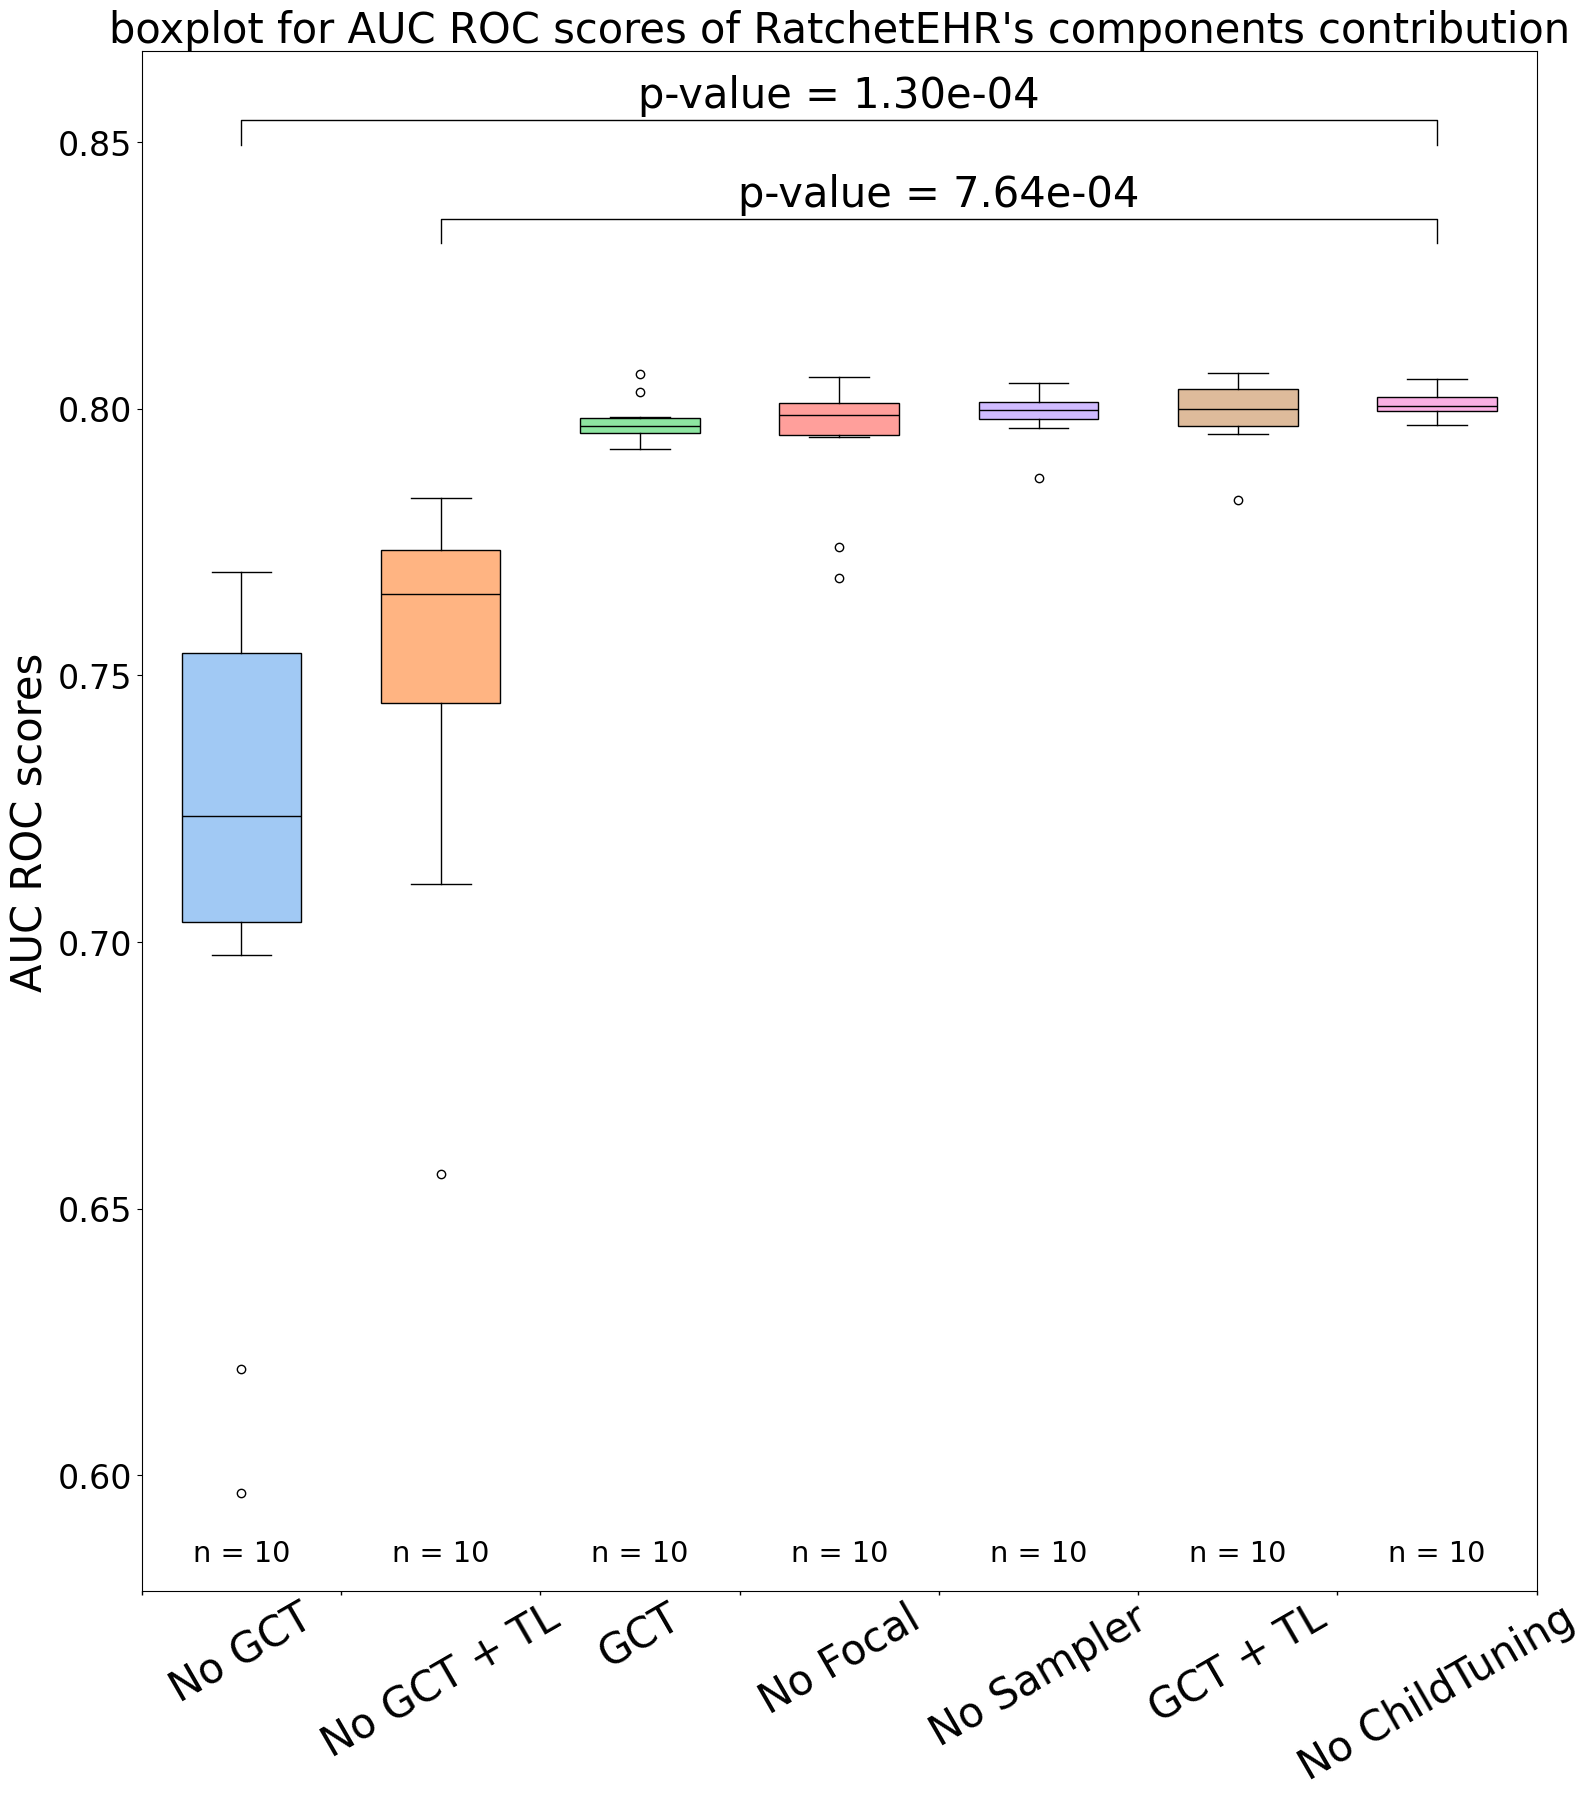

In [96]:
model_to_file = {
                "No Focal": output_path + 'ratchet_bce_loss/tl_reconstruction_output_bce_loss.tx', 
                "No ChildTuning": output_path + 'ratchet_no_child_tuning/tl_reconstruction_output_no_child_tuning.tx',
                "No Sampler": output_path + 'ratchet_no_sampler/tl_reconstruction_output_no_sampler.tx',
                'No GCT': output_path + 'ratchet_no_gct/tl_reconstruction_no_gct.txt', 
                'No GCT + TL': output_path + 'ratchet_no_gct_tl/tl_reconstruction_no_gct_tl.txt', 
                'GCT': output_path + '/model/our_model_output.txt',
                'GCT + TL': output_path + 'ratchet_tl/tl_reconstruction_output.tx'}
model_to_roc_scores = {model: read_file(file) for model, file in model_to_file.items()}
box_and_whisker(list(model_to_roc_scores.values()),
                 "boxplot for AUC ROC scores of RatchetEHR's components contribution", 
                 "AUC ROC scores", model_to_file.keys(), "Contribute", figsize=(18, 20))

In [97]:
results = [(np.array(model_to_roc_scores[k]).mean(), np.array(model_to_roc_scores[k]).std()) for k in model_to_roc_scores if k == "No ChildTuning"]

In [98]:
results

[(0.8009856630824366, 0.0023513733496525148)]